In [1]:
import stim, pymatching as pm, numpy as np
from IPython.display import SVG

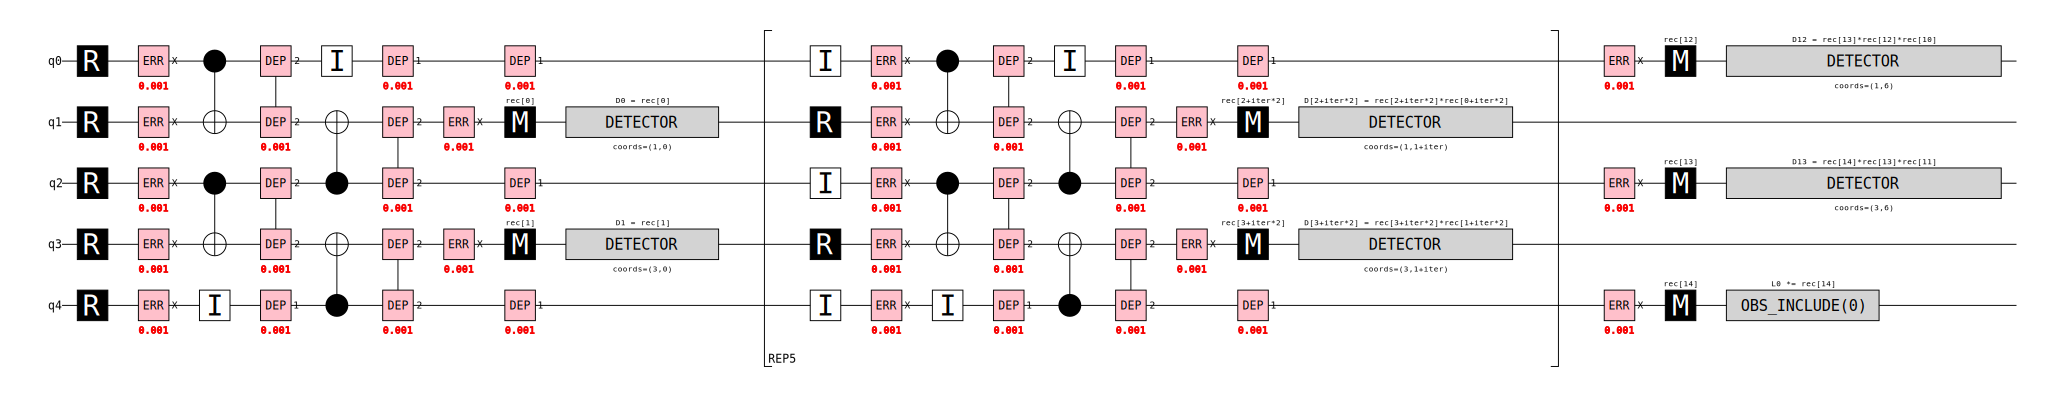

In [4]:

circ_str = """
    R 0 1 2 3 4
    X_ERROR(0.001) 0 1 2 3 4
    CX 0 1 2 3
    I 4
    DEPOLARIZE2(0.001) 0 1 2 3
    DEPOLARIZE1(0.001) 4
    CX 2 1 4 3
    I 0
    DEPOLARIZE1(0.001) 0
    DEPOLARIZE2(0.001) 2 1 4 3
    X_ERROR(0.001) 1 3
    M 1 3
    DEPOLARIZE1(0.001) 0 2 4
    DETECTOR(1, 0) rec[-2]
    DETECTOR(3, 0) rec[-1]

    REPEAT 5 {
        R 1 3
        I 0 2 4
        X_ERROR(0.001) 0 1 2 3 4
        CX 0 1 2 3
        I 4
        DEPOLARIZE2(0.001) 0 1 2 3
        DEPOLARIZE1(0.001) 4
        CX 2 1 4 3
        I 0
        DEPOLARIZE1(0.001) 0
        DEPOLARIZE2(0.001) 2 1 4 3
        X_ERROR(0.001) 1 3
        M 1 3
        DEPOLARIZE1(0.001) 0 2 4
        SHIFT_COORDS(0, 1)
        DETECTOR(1, 0) rec[-2] rec[-4]
        DETECTOR(3, 0) rec[-1] rec[-3]
    }
    X_ERROR(0.001) 0 2 4
    M 0 2 4
    SHIFT_COORDS(0, 1)
    DETECTOR(1, 0) rec[-2] rec[-3] rec[-5]
    DETECTOR(3, 0) rec[-1] rec[-2] rec[-4]

    OBSERVABLE_INCLUDE(0) rec[-1]
"""
c = stim.Circuit(circ_str)
display(SVG(str(c.diagram("timeline"))))


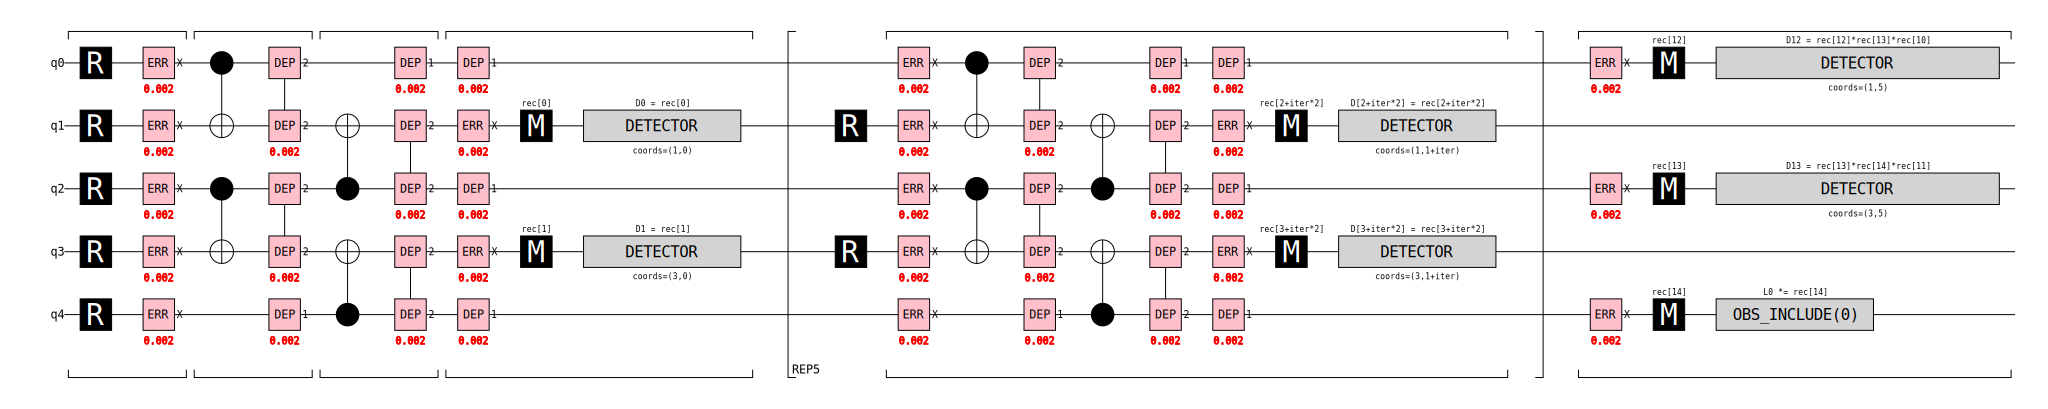

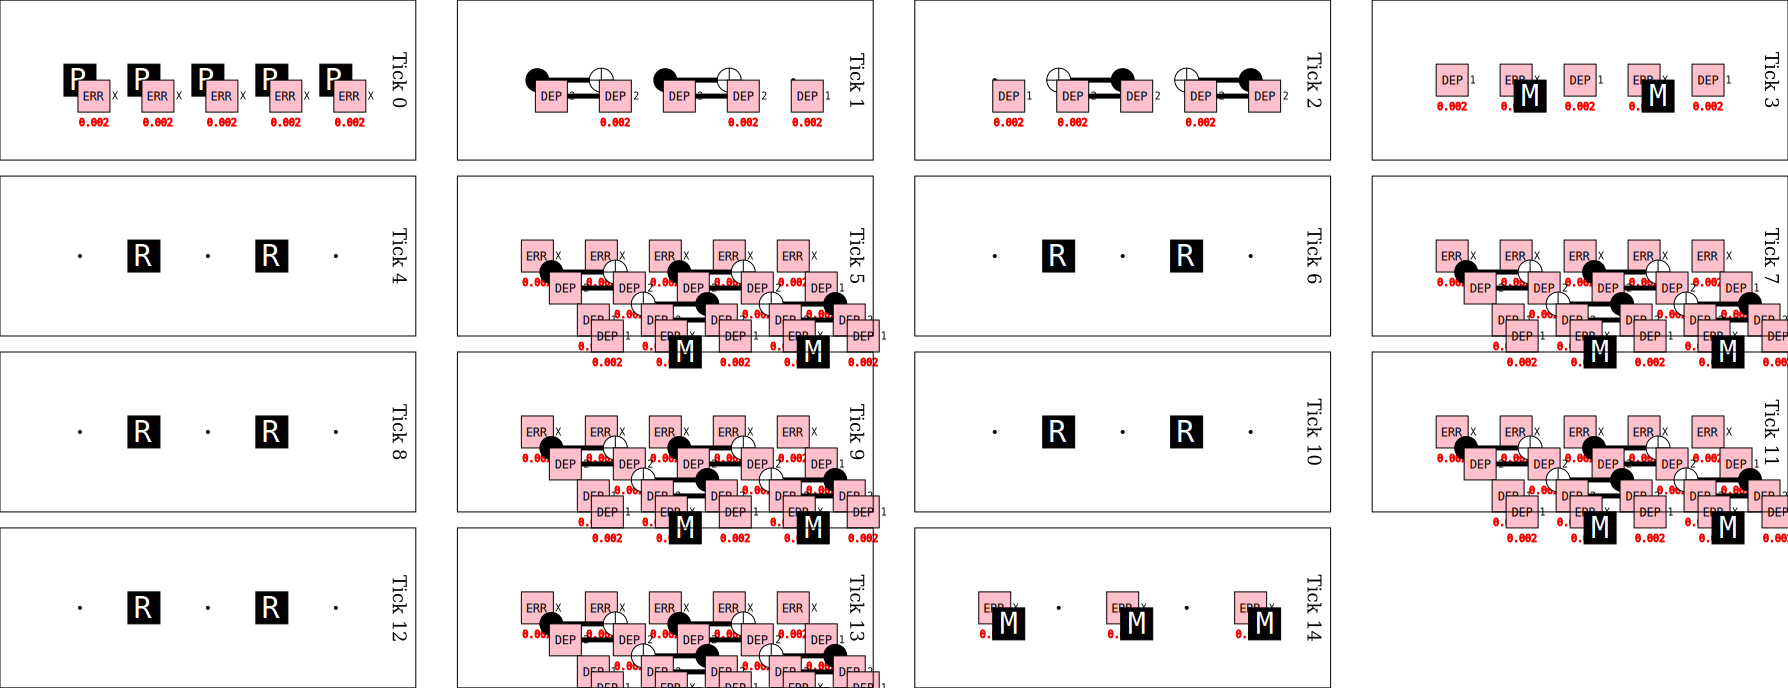

In [ ]:
def repeating_part(d: int, p: float, n: int, qubits, q_dat, q_meas) -> stim.Circuit:
    c = stim.Circuit()
    c.append("R", q_meas)
    for i in qubits:
        c.append("X_ERROR", [i], p)
    c.append("TICK")
    for i in q_meas:
        c.append("CNOT", [i-1, i])
    for i in q_meas:
        c.append("DEPOLARIZE2", [i-1, i], p)
    c.append("DEPOLARIZE1", [n-1], p)
    for i in q_meas:
        c.append("CNOT", [i+1, i])
    for i in q_meas:
        c.append("DEPOLARIZE2", [i+1, i], p)
    c.append("DEPOLARIZE1", 0, p)
    for i in q_meas:
        c.append("X_ERROR", [i], p)
    for i in q_dat:
        c.append("DEPOLARIZE1", [i], p)
    for i in q_meas:
        c.append("M", [i])
    c.append("SHIFT_COORDS", [], [0, 1])
    for i in q_meas:
        c.append("DETECTOR", [stim.target_rec(-len(q_meas) + int((i-1)/2))], [i,0])
    c.append("TICK")

    return c

def repetition_circuit_realistic_noise(d: int, p: float, rounds: int) -> stim.Circuit:
    n = d * 2 - 1
    c = stim.Circuit()
    qubits = range(n)
    q_dat = qubits[::2]
    q_meas = qubits[1::2]
    c.append("R", range(n))
    c.append("X_ERROR", range(n), p)
    c.append("TICK")
    for i in q_meas:
        c.append("CNOT", [i-1, i])
    for i in q_meas:
        c.append("DEPOLARIZE2", [i-1, i], p)
    c.append("DEPOLARIZE1", [n-1], p)
    c.append("TICK")
    for i in q_meas:
        c.append("CNOT", [i+1, i])
    for i in q_meas:
        c.append("DEPOLARIZE2", [i+1, i], p)
    c.append("DEPOLARIZE1", 0, p)
    c.append("TICK")
    for i in q_meas:
        c.append("X_ERROR", [i], p)
    for i in q_dat:
        c.append("DEPOLARIZE1", [i], p)
    for i in q_meas:
        c.append("M", [i])
    for i in q_meas:
        c.append("DETECTOR", [stim.target_rec(-len(q_meas) + int((i-1)/2))], [i,0])
    c.append("TICK")
    c += rounds*repeating_part(d, p, n, qubits, q_dat, q_meas)
    
    for i in q_dat:
        c.append("X_ERROR", [i], p)
    for i in q_dat:
        c.append("M", [i])
    for i in q_meas:
        c.append("DETECTOR", [stim.target_rec(- d + int(i/2)), stim.target_rec(- d + int(i/2) + 1), stim.target_rec(- d + int(i/2) - d + 1)], [i,0])
    c.append("OBSERVABLE_INCLUDE", [stim.target_rec(-1)], 0)
    return c

d = 3
p = 0.002
rounds = 5
c = repetition_circuit_realistic_noise(d, p, rounds)

display(SVG(str(c.diagram("timeline"))))
display(SVG(str(c.diagram("timeslice-svg"))))